In [1]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [2]:
# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/scrape/bin/python'

In [3]:
# os, shutil used for copying/moving files
import os
import shutil
# shutil.copyfile('src', 'dst')
# shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

import numpy as np
import pandas as pd
import openpyxl

In [ ]:
# add path if needed
# sys.path.append('/Users/edwardterrell/Desktop/covid_machinations')

In [ ]:
# This code was used when repeatedly modifying date_checker
#import importlib
#importlib.import_module('state_country_dicts') #note difference between this and reload
#importlib.reload(dc) #date_checker

In [4]:
# pie_dict module contains only one function (pie) which reduces 
# the number of types into only seven basic categories for creating piecharts
from pie_dict import pie

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

import dateutil.parser
import time

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-04-11'

### The following cell determines if the Colorado site has been updated

In [6]:
# outbreaks files are updated on the web once a week
# date_checker is a python module that compares the date of the
# last saved outbreak.xlsx file to the date of the outbreak.xlsx
# file on the web
import date_checker as dc

#Returns the date of the latest saved spreadsheet.
previous = dc.get_date()

# compare function outputs a tuple: url link and a date
# and prints the dates of the spreadsheets
names = dc.compare(previous)

latest saved spreadsheet is 2021-04-07
Site NOT updated: current date of spreadsheet is 2021-04-07


In [7]:
# Examine the tuple
print (names[0])
print (names[1])

https://covid19.colorado.gov/sites/covid19/files/2021-04/covid-19_outbreak_weekly_report_04-07-2021.xlsx
2021-04-07 00:00:00


### Colorado Outbreak data

In [8]:
import urllib
import requests
import re

url = 'https://covid19.colorado.gov/data/outbreak-data'

In [9]:
!ls *.xlsx

temp.xlsx


In [10]:
rm *.xlsx

In [11]:
ls covid_data_update/

us_2021-04-11.png
us_FL_IL_MI_last_60_days_2021-04-11.png
us_FL_IL_MI_last_90_days_2021-04-11.png
us_rolling_avg_2021-04-11.png
world_2021-04-11.png
world_UK_IT_last_60_days_2021-04-11.png
world_UK_IT_last_90_days_2021-04-11.png
world_rolling_avg_2021-04-11.png


In [12]:
def get_weekly_report(names):
    '''
    Opens the web page and creates a copy of the xlsx file,
    which is then archived in the directory covid_data.
    
    names is the tuple variable created by data_checker.compare()
    the two components of names are: 1) url link and 2)date in string format
    
    returns a dataframe
    '''
    link = names[0]
    response = requests.get(link)
    with open ('temp.xlsx', 'wb') as file:
        file.write(response.content)
    
    # create a permanent copy of the xlsx file in the covid_data directory
    current = names[1]
    current_report = current.strftime('%Y-%m-%d')
    shutil.copyfile('temp.xlsx', f'covid_data/covid_report_{current_report}.xlsx')
    
    df = pd.read_excel('temp.xlsx',sheet_name='Active',engine='openpyxl',parse_dates=['Date reported to public health'])
    return df

In [17]:
df = get_weekly_report(names)
df.shape

(626, 65)

In [18]:
df = df.iloc[:,:16]
df

,Setting name,Investigation status,Date outbreak was considered closed:,COVID Setting Type,"If setting type is other, specify","Is this an At Risk Population? (Healthcare, Corrections, Highly Mobile, Schools, Critical Infrastructure)",Colorado county (exposure location),Date reported to public health,Total resident cases,Total staff cases,Total attendee cases,Total resident deaths,Total staff deaths,Total attendee deaths,Total cases,Total deaths
0,10 Barrel,Active,NaN,Bar/Tavern/Brewery,NaN,NaN,Denver,2021-04-02,NaN,6.0,NaN,NaN,NaN,NaN,6,0
1,287 S Starwood Rd Construction Site,Active,NaN,Construction Site,residential construction site,Yes,Pitkin,2020-07-30,NaN,17.0,NaN,NaN,NaN,NaN,17,0
2,3STEP Lacrosse,Active,NaN,Youth Sports/Activities,NaN,NaN,Denver,2021-03-27,NaN,5.0,NaN,NaN,NaN,NaN,5,0
3,4th Judicial District Attorney's Office,Active,NaN,Law Enforcement Administration,NaN,Yes,El Paso,2021-03-08,NaN,9.0,NaN,NaN,NaN,NaN,9,0
4,ABC Development Center,Active,NaN,Child Care Center,NaN,Yes,Washington,2021-03-03,NaN,5.0,NaN,NaN,NaN,NaN,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,World Prayer Center,Active,NaN,Religious Facility,NaN,NaN,El Paso,2020-10-05,NaN,30.0,5.0,NaN,NaN,NaN,35,0
622,Yampa Sandwich Company- Steamboat Springs,Active,NaN,Restaurant - Sit Down,NaN,NaN,Routt,2021-03-22,NaN,2.0,NaN,NaN,NaN,NaN,2,0
623,Yampa Valley Electrical Association,Active,NaN,Other,Utility company,Yes,Routt,2020-12-16,NaN,4.0,NaN,NaN,NaN,NaN,4,0
624,Yasmeen's Bright Steps Academy,Active,NaN,Child Care Center,NaN,Yes,Arapahoe,2021-03-24,NaN,1.0,3.0,NaN,NaN,NaN,4,0


In [19]:
def polish_report(df):
    '''polish_report removes and reorders columns and assigns shortened names. It also
    creates a datetime index, changes strings to integers and handles NaNs
    Returns: a copy of the original df
    '''
    # eliminate unnecessary columns and re-order columns
    df = df.iloc[:,[-2,0,3,6,7,8,9,10]].copy()
    
    # shorten col names for easier manipulation
    df.columns = ['total','name','type', 'county','date','residents','staff','attendee']
    
    # use the date column as the index
    df.index = df.date
    df.drop('date',axis=1, inplace=True)
    
    # replace nuisance commas
    df.name = df.name.str.replace(',','_')
    
    # fill na with 0 and turn strings to integers
    df = df.fillna(0)
    df['attendee'] = df['attendee'].astype(int) 
    df['staff'] = df['staff'].astype(int) 
    df['residents'] = df['residents'].astype(int)
    
    return df

In [20]:
df = polish_report(df)
# Sanity Check!!!
df.sort_index(ascending=False).head(10)

,total,name,type,county,residents,staff,attendee
date,,,,,,,
2021-04-07,3,Aspen Grove Animal Clinic PC,Other,Larimer,0,3,0
2021-04-07,3,Front Range Community College Westminster Camp...,College/University,Adams,0,1,2
2021-04-07,3,Camp Elim,Overnight Camp,Teller,0,3,0
2021-04-06,2,Caley Ridge Assisted Living Community (230487)...,Healthcare - Assisted Living,Arapahoe,0,2,0
2021-04-06,2,Costco Wholesale #440: April 2021,Retailer,Jefferson,0,2,0
2021-04-06,5,RB Law Offices,Office/Indoor Workspace,Weld,0,5,0
2021-04-06,24,High Mountain Institute,School K-12,Lake,0,0,24
2021-04-06,4,Lowry Park Apartments,Other,Denver,0,4,0
2021-04-06,4,Healthy Hounds and Fat Cats,Retailer,La Plata,0,4,0


In [21]:
# total active
print(f'There are {df.shape[0]} active outbreak sites in Colorado')

There are 626 active outbreak sites in Colorado


### outbreaks

In [22]:
# this saves four csv files for easy viewing access on an ipad organized by county,type, total and date
# use of f-string to allow 'day' to be interpreted correctly
df.sort_values(by='county', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-COUNTY-{day}.csv')

df.sort_values(by='type', inplace=True)
df.to_csv(f'./covid_data_update/outbreaks-TYPE-{day}.csv')

df.sort_values(by='total', inplace=True,ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-TOTAL-{day}.csv')

df =df.sort_index(ascending=False)
df.to_csv(f'./covid_data_update/outbreaks-DATE-{day}.csv')


print(f'There are {df.total.sum()} active cases in Colorado')

There are 21857 active cases in Colorado


In [23]:
# prompt user to select month (default to current month)
m = input('Select the month by number:') or names[1].month
y = names[1].year
m = int(m)
print(f'For year {y} and month {m}')

Select the month by number: 4


For year 2021 and month 4


In [24]:
# dfy is the df for the current year
dfy = df[df.index.year==y].copy()

In [25]:
# df_month is the df for the selected month
df_month = dfy[dfy.index.month==m].copy()

In [26]:
df_month.reset_index(inplace=True)
df_month = df_month[['total','name','type','county']]

In [27]:
df_month.to_csv(f'./covid_data/covid_2021_{m}.txt')

In [28]:
# get number of sites and total cases for the month
s = df_month.shape[0]
t = df_month.total.sum()
print(f'There were an additional {s} outbreak sites in Colorado this month.')
print (f'These represent a total of {t} new cases.')

There were an additional 97 outbreak sites in Colorado this month.
These represent a total of 410 new cases.


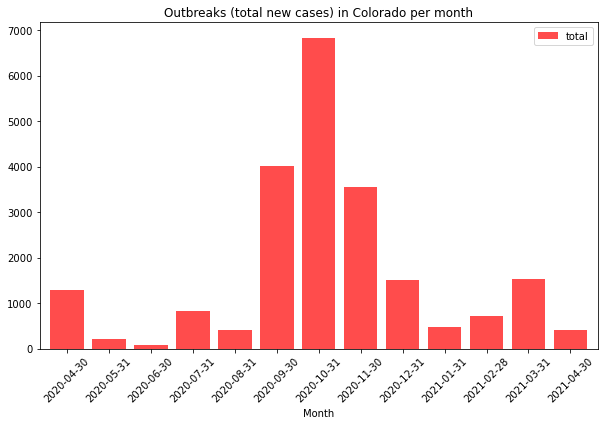

In [29]:
dfm = df.resample('M').sum()

dfm['Month'] = dfm.index.date
dfm

dfm[['Month','total']].plot.bar(figsize=(10,6), \
                                x='Month',rot=45, width=.8, \
                                color="red",alpha=.7,\
                                title="Outbreaks (total new cases) in Colorado per month")
plt.savefig(f'./covid_data_update/outbreaks-per-month-{day}.png');

In [30]:
dfm

,total,residents,staff,attendee,Month
date,,,,,
2020-04-30,1297,1183,114,0,2020-04-30
2020-05-31,211,0,211,0,2020-05-31
2020-06-30,82,0,82,0,2020-06-30
2020-07-31,829,381,448,0,2020-07-31
2020-08-31,408,0,404,4,2020-08-31
2020-09-30,4007,0,520,3487,2020-09-30
2020-10-31,6830,2141,1027,3662,2020-10-31
2020-11-30,3543,1781,1574,188,2020-11-30
2020-12-31,1518,474,807,237,2020-12-31


In [ ]:
# list all active cases in Boulder County
boulder = df[df.county=='Boulder']
bc = boulder.total.sum()
print(f'There are {bc} active cases in Boulder County')

In [ ]:
boulder = boulder.sort_index(ascending=False)
boulder.to_csv(f'./covid_data_update/boulder-{day}.csv')
boulder

### Create Pie Chart

In [ ]:
# total number of active cases
s = df.total.sum()
s

In [ ]:
# list of major types by percent of total
df_percent = df.groupby('type').total.sum()/s
print (f'These represent {df_percent[df_percent > .01].sum()*100:.0f}% of all outbreak cases')
df_percent[df_percent > .01]

In [ ]:
# custom function from pie_dict 
from pie_dict import pie

In [ ]:
df_pie = pie (df)
df_pie.head()
pie_list = np.array(['College/University', 'Jail/Prison', 'Other',
       'Office/Mfg/Dist/Construction', 'Healthcare', 'Resturant/Retail',
       'Day Care/School'], dtype=object)

In [ ]:
'''test = df.type.unique()
test = np.append(test,['Social Gathering','Travel'])
len(test)
'''

In [ ]:
df.type.unique()

In [ ]:
test = df.type.unique()
if len(test) != 7:
    more_types = [item for item in test if item not in pie_list]
    df.type = df.type.replace(dict.fromkeys(more_types, 'Other'))
    print(f'{more_types} were added to the category: Other')
else:
    print('No new types were added to the category: Other')

In [ ]:
df.total = df.total.astype(int)

p = df.groupby('type').total.sum()
print (p)
total_cases = p.sum()
total_cases

In [ ]:
# creates a pie chart of the current total active cases
my_colors = ['#f6eff7','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016450']

explode = (.1,0,0,0,0,0,0)

p.plot.pie(figsize=(8,8),explode=explode,autopct='%1.0f%%',
        shadow=True, colors=my_colors,startangle=-25);
plt.title(f'Covid Active Outreaks\n (active cases = {total_cases},       {day})\n')

plt.axis('equal')
plt.savefig(f'./covid_data_update/outbreaks-piechart-{day}.png');

### Displays all updated graphs files including those from covid.ipynb

In [ ]:
cd covid_data_update

In [ ]:
!ls -t1 | head -n 20 | grep -ve '^bolder' -ve 'png$' -ve 'xlsx$' > covid_text

!ls *.png > flist_of_covid_png 

import matplotlib.image as mpimg
# Loop through this list of images to read and plot them
with open('flist_of_covid_png') as f:
    png_str = f.read()
png_list = png_str.split('\n')[1:-1]

for file in png_list:
    img = mpimg.imread(file)
    fig,ax = plt.subplots(1,1,figsize=(10,5))
    plt.imshow(img)
    plt.show();
plt.close('all');

In [ ]:
# These were helper files and are not needed any longer
!rm -f covid_text
!rm -f flist_of_covid_png
!rm -f temp.xlsx

In [ ]:
cd ..